In [13]:
%pylab inline

from functools import partial
from typing import Callable, List
import warnings

import pandas as pd
from scipy.stats import (multivariate_normal as mnorm,
                         truncnorm as sp_truncnorm,
                         norm as sp_norm,
                         chi2)
import seaborn as sns

sns.set(style='ticks', context='talk')

def truncnorm(a, b, loc=0, scale=1):
    a, b = (a - loc)/scale, (b - loc)/scale
    return sp_truncnorm(a=a, b=b, loc=loc, scale=scale)

Populating the interactive namespace from numpy and matplotlib


/home/mtambos/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cov']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# General purpose Gibbs Sampler

In [14]:
def gibbs(X_init: np.ndarray, iterations: int, distributions: List[Callable]) -> np.ndarray:
    _, M = X_init.shape
    assert M == len(distributions)
    ret_val = np.zeros((iterations, M))
    ret_val[0] = X_init
    for t in range(1, iterations):
        X = ret_val[t - 1]
        for j in range(M):
            X[j] = distributions[j](X, j)
    return ret_val

## Test

In [15]:
M = 2
mu = np.random.rand(M) * 100

while True:
    try:
        cov = np.random.rand(M, M)
        cov = (cov + cov.T)/2
        np.linalg.cholesky(cov)
        break
    except np.linalg.LinAlgError:
        pass
print(mu)
print(cov)

[ 32.73873001  22.74784432]
[[ 0.952111    0.78830063]
 [ 0.78830063  0.97411803]]


x    32.750373
y    22.762539
dtype: float64
          x         y
x  0.951302  0.793006
y  0.793006  0.975011


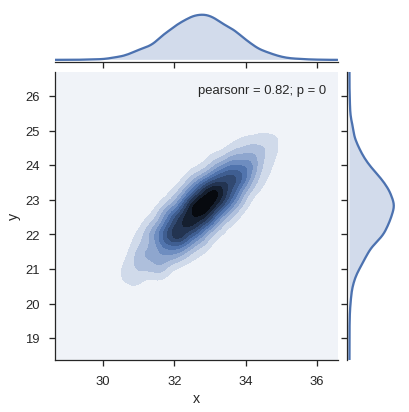

In [16]:
norm_df = pd.DataFrame(mnorm(mu, cov).rvs(10000), columns=['x', 'y'])
print(norm_df.mean())
print(norm_df.cov())
sns.jointplot(x='x', y='y', data=norm_df, kind='kde');

In [17]:
def f1(X, j, mu, cov):
    sigma_1 = cov[0, 0]**0.5
    sigma_2 = cov[1, 1]**0.5
    rho = cov[0, 1]/(sigma_1*sigma_2)
    return sp_norm(loc=mu[0] + (sigma_1/sigma_2)*rho*(X[1] - mu[1]),
                   scale=(1 - rho**2)*sigma_1**2).rvs()


def f2(X, j, mu, cov):
    sigma_1 = cov[0, 0]**0.5
    sigma_2 = cov[1, 1]**0.5
    rho = cov[0, 1]/(sigma_1*sigma_2)
    return sp_norm(loc=mu[1] + (sigma_2/sigma_1)*rho*(X[0] - mu[0]),
                   scale=(1 - rho**2)*sigma_2**2).rvs()


distributions = [partial(f1, mu=mu, cov=cov), partial(f2, mu=mu, cov=cov)]
iterations = 100000
samples = gibbs(np.zeros((1, 2)), iterations, distributions)
gibbs_df = pd.DataFrame(samples, columns=['x', 'y'])
print(gibbs_df.mean())
print(gibbs_df.cov())

x    14.328661
y     7.504262
dtype: float64
          x         y
x  0.100216  0.082747
y  0.082747  0.171910


9000
x    14.331167
y     7.513000
dtype: float64
          x         y
x  0.097643  0.081711
y  0.081711  0.174669


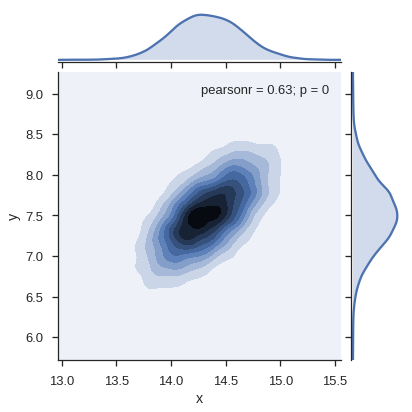

In [18]:
drop = 10000
thin = 10
thinned_df = gibbs_df.iloc[drop:iterations:thin]
print(len(thinned_df))
print(thinned_df.mean())
print(thinned_df.cov())
sns.jointplot(x='x', y='y', data=thinned_df, kind='kde');

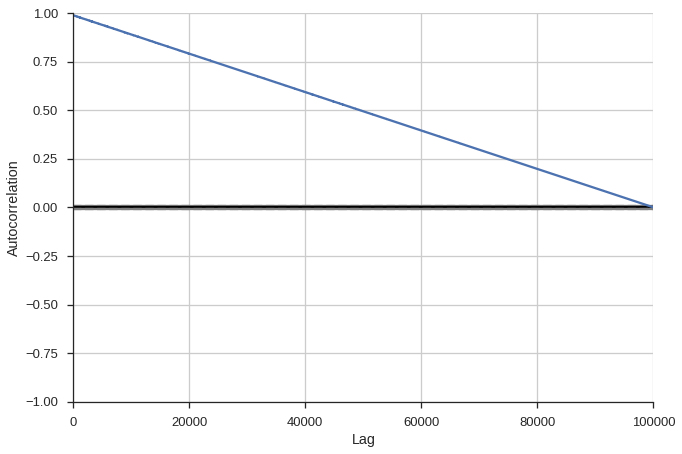

In [20]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(gibbs_df)
sns.despine()

# Variable Selection Code

In [112]:
def bayes_factor(β_bar, β_old, var_star, τ):
    """
    REVIEW!!!! Attempt at not considering truncated normals
    """
    bf = np.exp(β_bar**2/(2*var_star) - β_old**2/(2*τ**2))
    bf *= var_star / τ
    return bf


def variable_selection(X, y, β, var, p, τ, ν, iterations):
    """
    REVIEW!!!! Attempt at not considering truncated normals
    """
    N, M = X.shape
    
    chain = np.zeros((iterations, M + 1))
    probs = np.zeros((iterations, M))
    for i in range(iterations):
        for j in range(M):
            X_j = X[:, j]
            X_sq_sum = (X_j**2).sum()
            β_no_j = β.copy()
            β_no_j[j] = 0
            z = y - X @ np.r_['0,2', β_no_j].T
            b = (X_j * z).sum() / X_sq_sum
            ω_sq = var / X_sq_sum
            var_star = 1/(ω_sq + 1/τ[j]**2)
            β_bar = var_star*(b/ω_sq + β[j]/(τ[j]**2))
            bf = bayes_factor(β_bar, β[j], var_star, τ[j])
            p_bar = p[j]/(p[j] + (1-p[j])*bf)
            p[j] = p_bar
            probs[i, j] = p_bar
            if np.random.rand() <= p_bar:
                β[j] = 0
            else:
                β[j] = sp_norm.rvs(loc=β_bar, scale=var_star)
            chain[i, j] = β[j]
        err = y - X@np.r_['0,2', β].T
        err = err.T @ err
        var = (var + err)/chi2.rvs(ν + N)
        chain[i, M-1] = var

    return β, var, chain, probs

## Test

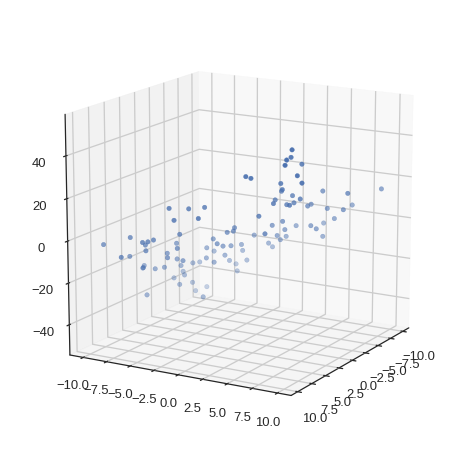

In [108]:
X = np.random.rand(100, 2) * 20 - 10
Y = X @ [[2], [3]] + np.random.randn(100, 1)*5

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*X.T, Y)
ax.view_init(15, 30)

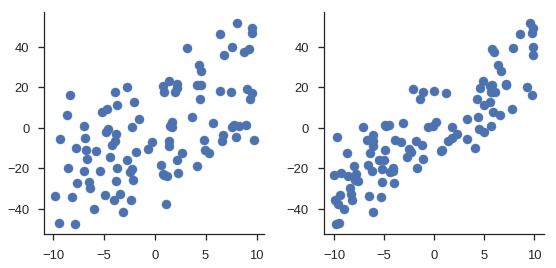

In [111]:
_, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1, ax2 = axes
ax1.scatter(X[:, 0], Y)
ax2.scatter(X[:, 1], Y)
plt.tight_layout()
sns.despine()

In [113]:
β_zero = np.array([0, 0])
var_zero = 10000
p = np.array([0.5, 0.5])
τ = np.ones_like(β_zero)
ν = 2
iterations = 1000
β, var, chain, probs = variable_selection(X, Y, β_zero, var_zero, p, τ, ν, iterations)

/home/mtambos/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/mtambos/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
